In [1]:
library(INLA)
library(Matrix)
library(ggplot2)
library(viridis)

#################################
# Fitting a spatial-only coregionalization model. The model is
#
# gedi(s) = int_gedi + A_1(s)w_1 + \epsilon_gedi(s)
# nfi(s) = int_gedi + \beta*A_1(s)w_1 + A_1(s)w_2 + \epsilon_nfi(s)
#
# There are two SPDE Gaussian fields now, w_1 and w_2. 
# The gedi and nfi are able to share information now because w_1 appears in both.
# Notice that in the nfi equation, w_1 is scaled by coefficient \beta.
# If \beta = 0, that means no relationship between gedi and nfi.
# If the variance of \beta*w_1 is large relative to the variance of the remaining terms, A_1(s)w_2 + \epsilon_nfi(s),
# that indicates a strong relationship between the two.
# Assuming a good relationship, the dense gedi shots help us learn w_1 at a fine resolution,
# which in turn helps us predict nfi.
#################################



#########################
# Simulate data
#########################

# This is a silly function I wrote to convert sigma/range pairs into INLA's internal parametrization.
# Only necessary for simulation, you can ignore.
reg2theta = function(reg, nu = 1, alpha = 2){
  sig = reg[1]
  rho = reg[2]
  log.kappa = log(8*nu)/2 - log(rho)
  log.tau = 0.5*(lgamma(nu) - lgamma(alpha) - log(4*pi)) - log(sig) - nu*log.kappa
  theta = c(log.tau, log.kappa)
  return(theta)
}

Warning message:
“package ‘INLA’ was built under R version 4.4.2”
Loading required package: Matrix

This is INLA_24.12.11 built 2024-12-11 19:58:26 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Loading required package: viridisLite



In [14]:
n_nfi = 250
n_gedi = 5e+3

# parameters

sigma1 = 1
range1 = 0.075
theta1 = reg2theta(c(sigma1, range1)) # INLA's internal parametrization
tau1 = 0.5

sigma2 = sqrt(0.25)
range2 = 0.15
theta2 = reg2theta(c(sigma2, range2)) # INLA's internal parametrization
tau2 = 0.1

beta = sqrt(0.75)
intercept_gedi = 3
intercept_nfi = 4

[1] 235

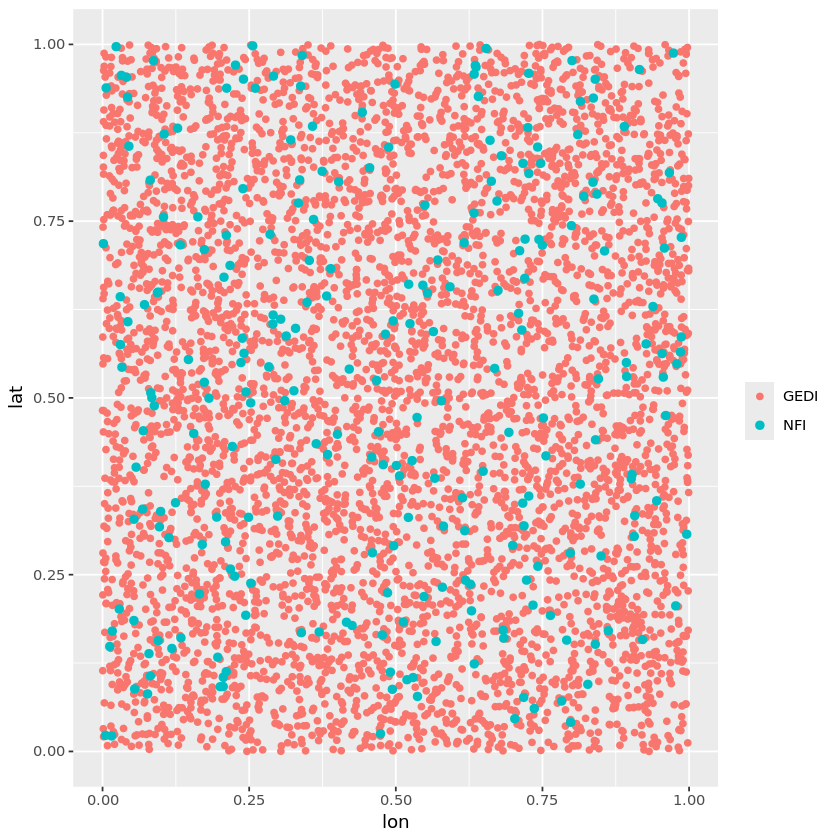

[1] 236

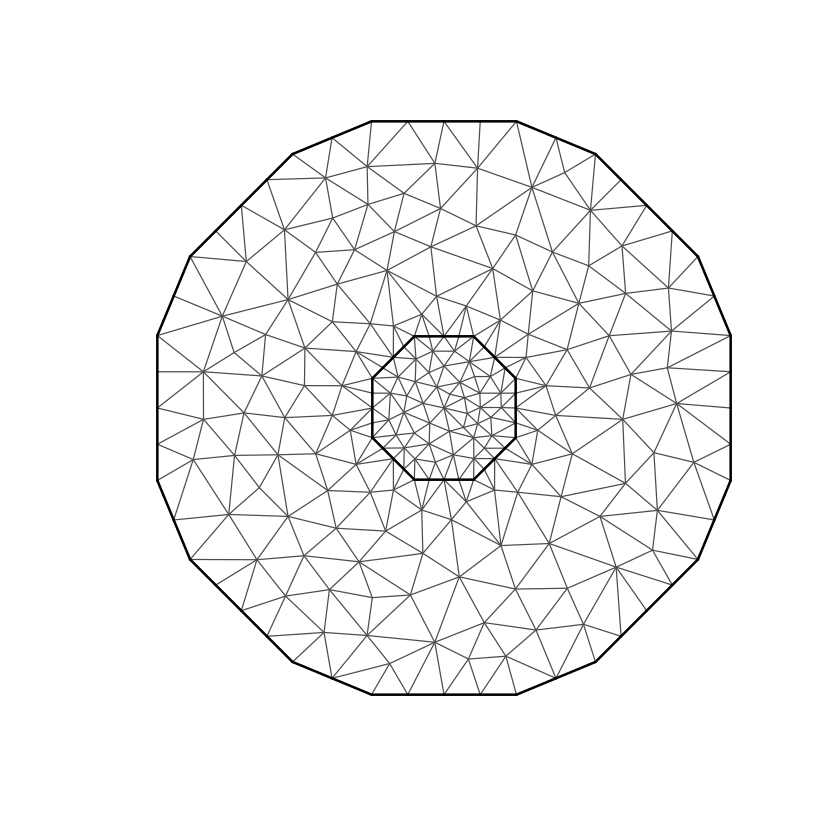

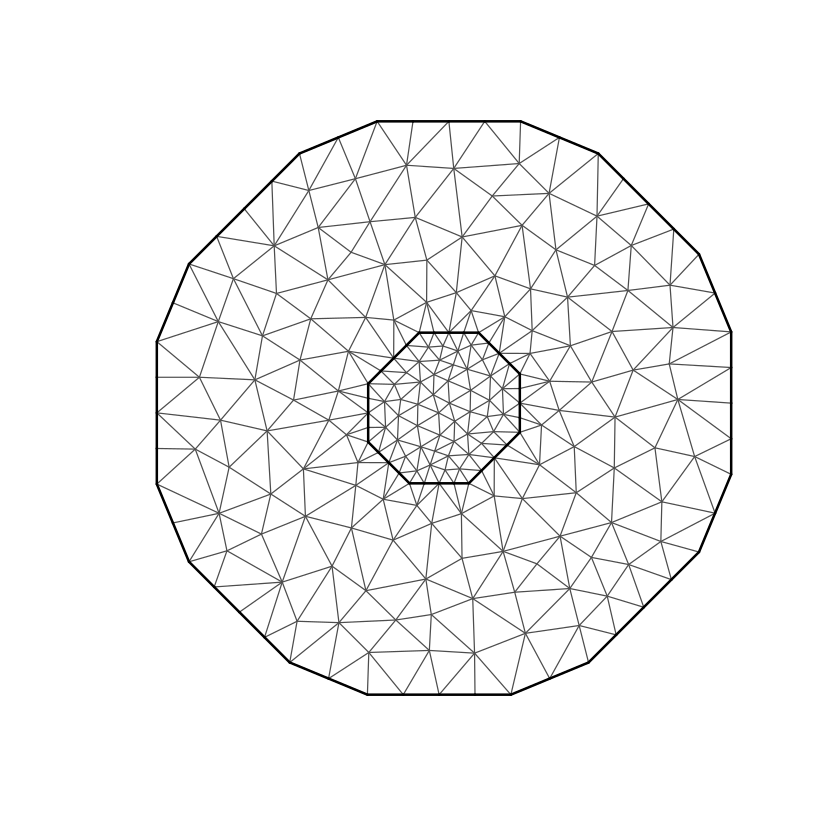

In [15]:
# locs n meshes

set.seed(96)

loc_gedi = cbind(runif(n_gedi), runif(n_gedi))

loc_nfi = cbind(runif(n_nfi), runif(n_nfi))

ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = "GEDI")) +
  geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = "NFI"), size = 2) +
  xlab("lon") + ylab("lat") + labs(col = "")


mesh1 = inla.mesh.2d(loc = loc_gedi, 
                     max.edge = c(range1/5, range1),
                     cutoff = c(range1/5),
                     offset = c(range1, 3*range1))

mesh1$n  

plot(mesh1)

mesh2 = inla.mesh.2d(loc = loc_nfi, 
                     max.edge = c(range2/5, range2),
                     cutoff = c(range2/5),
                     offset = c(range2, 3*range2))

mesh2$n  

plot(mesh2)

In [16]:
# Sim Gaussian fields and data

spde1 = inla.spde2.matern(mesh1)
spde2 = inla.spde2.matern(mesh2)

Q1 = inla.spde2.precision(spde1, theta1)
w1 = inla.qsample(Q = Q1)

Q2 = inla.spde2.precision(spde2, theta2)
w2 = inla.qsample(Q = Q2)

A1_gedi = inla.spde.make.A(mesh1, loc_gedi)
A1_nfi = inla.spde.make.A(mesh1, loc_nfi)
A2_nfi = inla.spde.make.A(mesh2, loc_nfi)

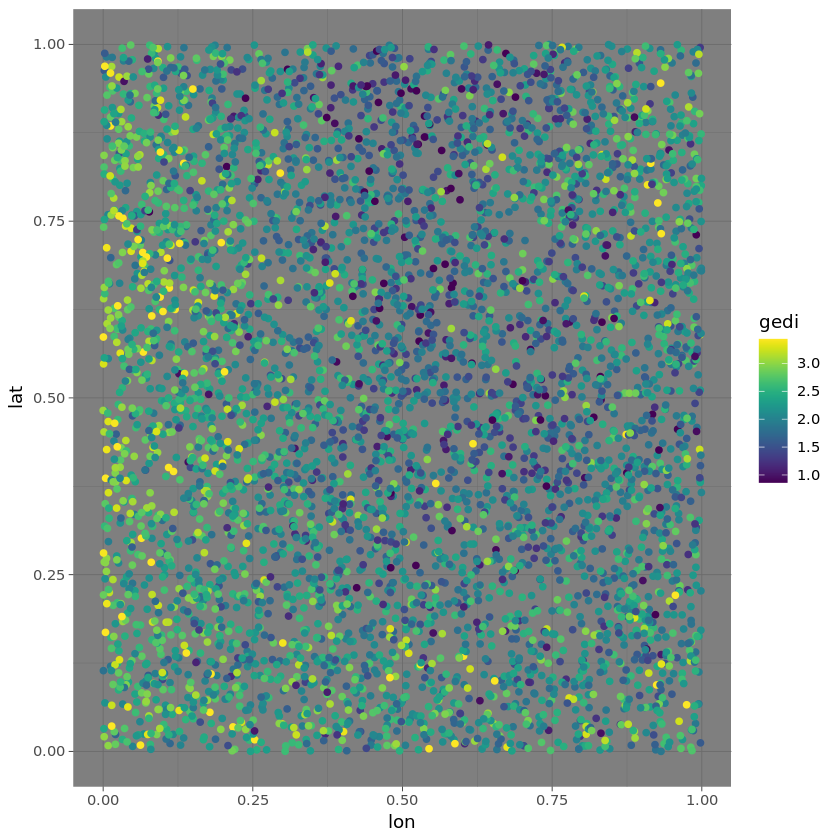

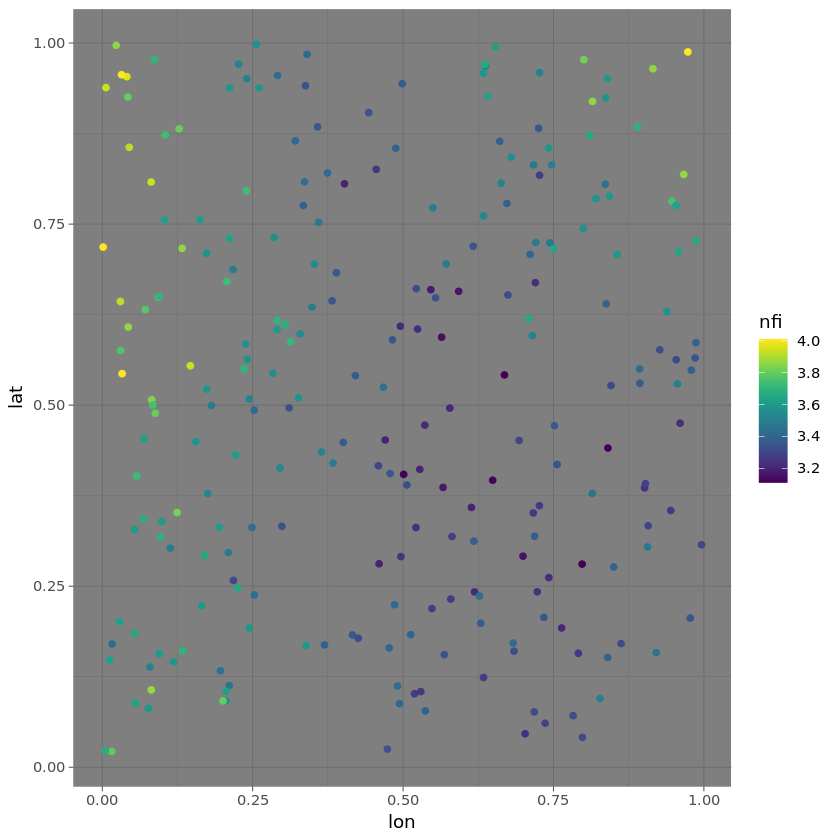

In [17]:
gedi = drop(
  intercept_gedi + A1_gedi%*%w1 + rnorm(n_gedi, sd = tau1) 
  )

ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = gedi)) +
  scale_color_viridis(limits = quantile(gedi, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()

nfi = drop(
  intercept_nfi + beta*A1_nfi%*%w1 + A2_nfi%*%w2 + rnorm(n_nfi, sd = tau2)
)

ggplot() + geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = nfi)) +
  scale_color_viridis(limits = quantile(nfi, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat") + theme_dark()

In [18]:
###########################
###########################
# Fit coregionalization model
###########################
###########################

# Constructing the stacks and formula for coreg models is the weirdest bit.
# I'll try to explain it as I go.

# Make the gedi stack
stack_gedi = inla.stack(
  data = list(y = cbind(gedi, NA)), # Notice a leave a column open for the NFI observations...
  A = list(1, A1_gedi), # And my A's and effects only include things that are in the gedi equation.
  effects = list(int_gedi = rep(1,n_gedi), w1 = 1:mesh1$n)
)

# Make the nfi stack
stack_nfi = inla.stack(
  data = list(y = cbind(NA, nfi)), # See how the empty slot is swapped?
  A = list(1, A1_nfi, A2_nfi), # Again, only things in the nfi equation.
  effects = list(int_nfi = rep(1,n_nfi), w12 = 1:mesh1$n, w2 = 1:mesh2$n) # w12 is the 'copy' of w1 in the gedi equation, but it needs a unique name. We'll tell INLA it's a copy in the formula lower down.
)

stack_full = inla.stack(stack_gedi, stack_nfi) # Merge 'em.

# Create SPDE objects with PC priors.
spde1 = inla.spde2.pcmatern(
  mesh = mesh1,
  prior.range = c(0.1, 0.5), 
  prior.sigma = c(1, 0.5))

spde2 = inla.spde2.pcmatern(
  mesh = mesh2,
  prior.range = c(0.1, 0.5), 
  prior.sigma = c(1, 0.5))

# Our normal prior on the beta coefficient. It's a mean and precision parameterization (precision of 2 implies a SD of sqrt(1/2)).
beta_prior <- list(beta = list(prior = 'normal', param = c(1, 2)))

# Last weird bit. You need to list all terms in the equation. INLA will know which go to gedi and the nfi from your individual stacks.

form = y ~ -1 + int_gedi + 
  int_nfi + 
  f(w1, model = spde1) + 
  f(w12, copy = 'w1', fixed = FALSE, hyper = beta_prior) + # This is how we tell INLA w12 is a copy of w1. The 'fixed = FALSE' tells INLA it needs to estimate \beta, rather than fix it at some provided value (default is 1, I think?)
  f(w2, model = spde2)


# Let 'er rip.
coreg_mod = inla(form, rep('gaussian', 2), # The rep('gaussian', 2) tells INLA that both gedi and nfi are assumed to be gaussian.
               data = inla.stack.data(stack_full), 
               control.predictor = list(A = inla.stack.A(stack_full)),
               control.compute = list(config = T),
               verbose = T)

summary(coreg_mod)

Time used:
    Pre = 0.776, Running = 27, Post = 0.508, Total = 28.3 
Fixed effects:
          mean    sd 0.025quant 0.5quant 0.975quant  mode kld
int_gedi 2.869 0.386      2.103    2.865      3.655 2.865   0
int_nfi  3.997 0.345      3.308    3.997      4.689 3.997   0

Random effects:
  Name	  Model
    w1 SPDE2 model
   w2 SPDE2 model
   w12 Copy

Model hyperparameters:
                                             mean    sd 0.025quant 0.5quant
Precision for the Gaussian observations     3.898 0.078      3.748    3.897
Precision for the Gaussian observations[2] 97.379 8.887     80.959   97.011
Range for w1                                0.590 0.515      0.072    0.443
Stdev for w1                                2.848 2.410      0.661    2.164
Range for w2                                0.256 0.294      0.042    0.169
Stdev for w2                                2.351 1.743      0.372    1.898
Beta for w12                                0.804 0.052      0.702    0.803
                

Log precision for the Gaussian observations 
                                     1.3597447 
Log precision for the Gaussian observations[2] 
                                     4.5764901 
                             log(Range) for w1 
                                    -0.5957181 
                             log(Stdev) for w1 
                                     0.5997985 
                             log(Range) for w2 
                                    -2.0333145 
                             log(Stdev) for w2 
                                     0.8643118 
                           Beta_intern for w12 
                                     0.8005953

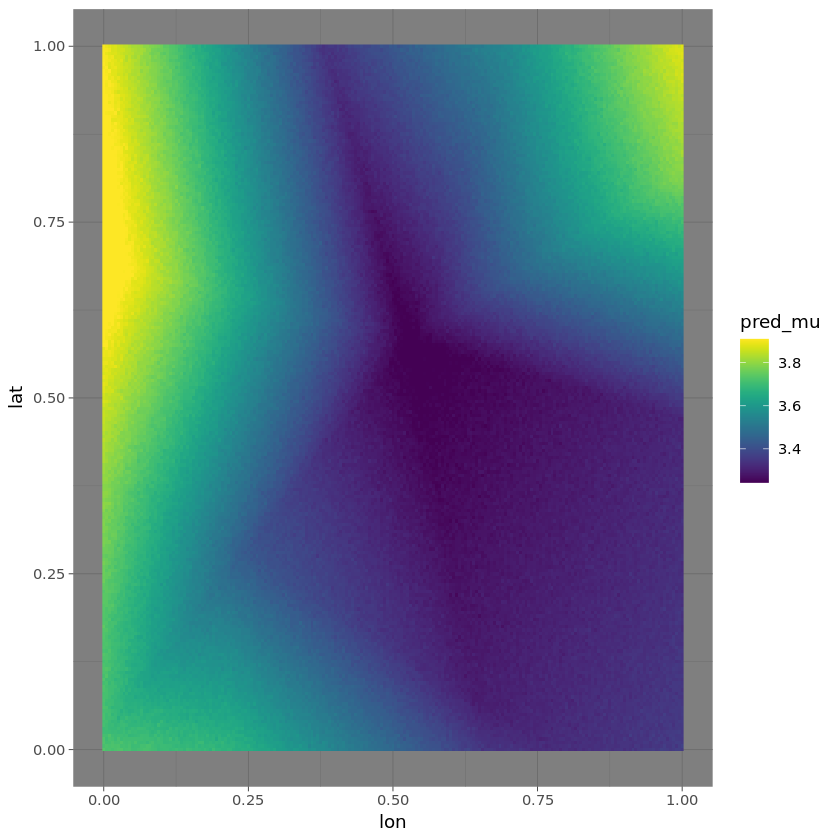

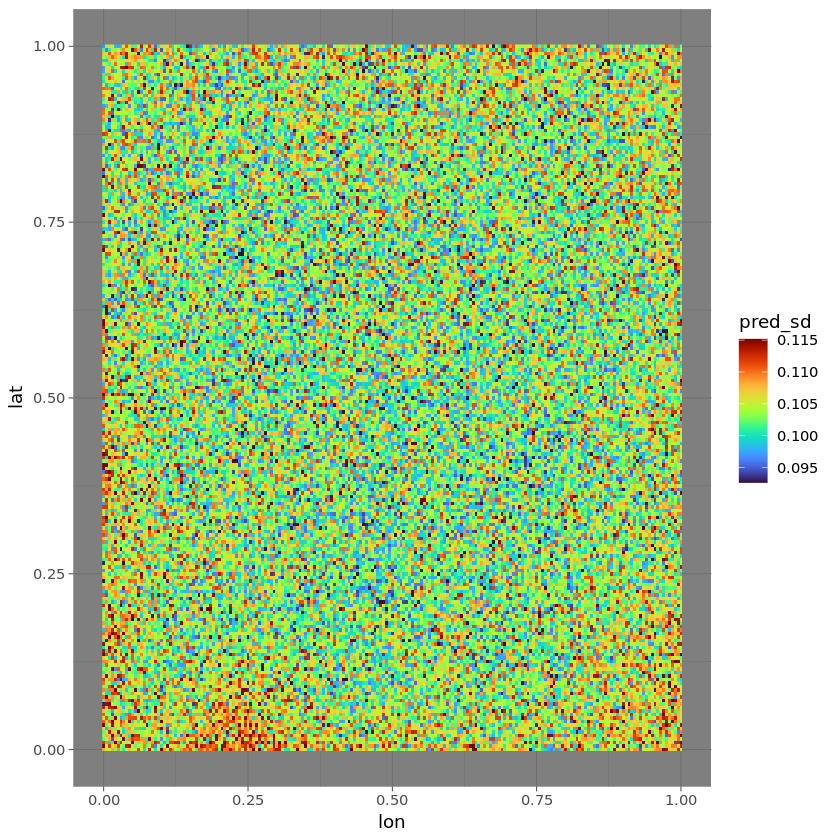

In [19]:
#####################
# Predict nfi on a regular grid.
# Hopefully this stuff makes sense from your previous work.
#########################
pred_res = 0.05

loc_pred = as.matrix(
  expand.grid(seq(0, 1, by = 0.005), seq(0, 1, by = 0.005))
)
n_pred = nrow(loc_pred)

A1_pred = inla.spde.make.A(mesh1, loc_pred)
A2_pred = inla.spde.make.A(mesh2, loc_pred)

nsamps = 250

sample = inla.posterior.sample(n = nsamps, coreg_mod)

coreg_mod$mode$theta # Super janky, but I used this to find out INLA is storing beta in theta[7] and the precision of \epsilon_nfi(s) in theta[2]. I use this info in the prediction function below.

pred_fun = function(...){
  drop(
    int_nfi + theta[7]*A1_pred%*%w1 + A2_pred%*%w2 + rnorm(n_pred, sd = sqrt(1/theta[2]))
  )
  }

pred_samps = inla.posterior.sample.eval(pred_fun, sample, )


pred_mu = rowMeans(pred_samps)
pred_sd = apply(pred_samps, 1, sd)

ggplot() + geom_raster(aes(x = loc_pred[,1], y = loc_pred[,2], fill = pred_mu)) +
  scale_fill_viridis(limits = quantile(pred_mu, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()

ggplot() + geom_raster(aes(x = loc_pred[,1], y = loc_pred[,2], fill = pred_sd)) +
  scale_fill_viridis(option = "turbo", limits = quantile(pred_sd, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()